In [5]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os,sys
from PIL import Image
import warnings
from scipy import ndimage

In [6]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, pad_size, stride = 1):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    patch_size = 2 * pad_size + 1
    is_2d = len(im.shape) < 3
    # iterating through all pixels of the original (unpadded) image
    for i in range(0, imgheight - 2 * pad_size, stride):
        for j in range(0 ,imgwidth - 2 * pad_size ,stride):
            if is_2d:
                im_patch = im[j:j + patch_size, i:i + patch_size]
            else:
                im_patch = im[j:j + patch_size, i:i + patch_size, :]
            list_patches.append(im_patch)
    return list_patches


## for testing purposes, making sure the cropping
# window behaves as expected
# def img_crop_test(im, pad_size, stride = 1):
#     list_patches = []
#     imgwidth = im.shape[0]
#     imgheight = im.shape[1]
#     patch_size = 2 * pad_size + 1
#     is_2d = len(im.shape) < 3
#     # iterating through all pixels of the original (unpadded) image
#     for i in range(0, imgheight - 2 * pad_size, stride):
#         for j in range(0 ,imgwidth - 2 * pad_size ,stride):
#             if i == 0 or i == 399 or j == 0 or j == 399:  # doesn't reach i/j = 400
#                 print(j, j+patch_size ,i ,i+patch_size)
# img_crop_test(np.asarray(pad_imgs[2]), pad_size = pad_size)

In [87]:
# image transformation functions

# convert RGB to grayscale
def rgb2gray(rgb):
    
    rgb = img_float_to_uint8(rgb)
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray


# pad immage edges with reflection
def make_pad_img(file_, pad_size, input_method, pic_size = [400, 400]):
    # pad_size is the padding size on each side
    # i.e. if patch is 13*13, pad_size should be (13-1) / 2
    if not(input_method in ['image', 'path']):
        raise Warning("input_method should be only one of image OR path")
    
    if input_method == 'path':
        Img = Image.open(file_)
    elif input_method == 'image':
        Img = img_float_to_uint8(file_)
    img = np.asarray(Img, np.int)
    shp = np.shape(img)
    img = img.transpose(2,0,1).reshape(3,pic_size[0],pic_size[1])
    
    pad_len = pic_size[0] + 2 * pad_size
    
    leftPad = np.ceil(float((pad_len - shp[0])) / 2)
    rightPad = np.ceil(float(pad_len - shp[0]) - leftPad)
    topPad = np.ceil(float((pad_len - shp[1])) / 2)
    bottomPad = np.ceil(float(pad_len - shp[1]) - topPad)
    pads = ((leftPad,rightPad),(topPad,bottomPad))
      
    img_arr = np.ndarray((3,pad_len,pad_len),np.int)
    for i,x in enumerate(img):
        x_p = np.pad(x,pads, 'reflect')
        img_arr[i,:,:] = x_p
    
    im_shp = np.shape(img_arr)
    ii = np.uint8(img_arr).transpose(1,2,0)
    
    im = Image.fromarray(np.array( (ii) ))

    return im


# Sobler filter function
def make_solber(file_, input_method, method = 'RGB', norm = False):
    if not(input_method in ['image', 'path']):
        raise Warning("input_method should be only one of image OR path")
    
    if not(method in ['RGB', 'L', '1']):
        raise Warning("input_method should be only one of RGB OR L OR 1")
    
    if input_method == 'path':
        img = Image.open(file_)
    elif input_method == 'image':
        img = Image.fromarray(file_)
    
    if method == 'RGB':
        r, g, b = img.split()
        solber_chan = []
        for channel in [r, g ,b]:
#             channel = channel.convert('L')
            dx = ndimage.sobel(channel, 0)  # horizontal derivative
            dy = ndimage.sobel(channel, 1)  # vertical derivative
            solber = np.hypot(dx, dy)  # magnitude
            if norm: solber = img_float_to_uint8(solber)
            solber_chan.append(solber)
    #     img = Image.merge("RGB", solber_chan)
        img = np.dstack(solber_chan)
    
    elif method in ['L', '1']:
        img = img.convert(method)
        dx = ndimage.sobel(img, 0)  # horizontal derivative
        dy = ndimage.sobel(img, 1)  # vertical derivative
        solber = np.hypot(dx, dy)  # magnitude
        if norm: solber = img_float_to_uint8(solber)
        img = solber
           
    return np.asarray(img)

# # test Solber filter
# run after creating padded images (pad_imgs)
temp = pad_imgs[0]
temp = img_float_to_uint8(load_image('C:\Users\Yarden-\Desktop\engine.png'))
temp = make_solber(temp, input_method = 'image', method = 'L', norm = True)
fig2 = plt.figure(figsize=(10, 10))
plt.imshow(temp, cmap='Greys_r')
# plt.imshow(temp)
print('image is of type '+ str(type(temp)))
print('image dimensiotns are ' + str(np.shape(temp)))

IndexError: too many indices for array

image is of type <type 'numpy.ndarray'>
image dimensiotns are (480, 640)
image is of type <type 'numpy.ndarray'>
image dimensiotns are (480, 640)


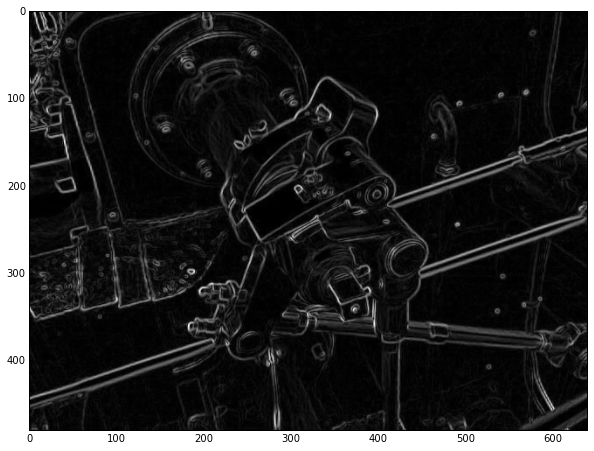

In [85]:
temp = load_image('C:\Users\Yarden-\Desktop\engine.png')
temp = rgb2gray(temp)

print('image is of type '+ str(type(temp)))
print('image dimensiotns are ' + str(np.shape(temp)))

# im = temp.astype('int32')
dx = ndimage.sobel(im, 0)  # horizontal derivative
dy = ndimage.sobel(im, 1)  # vertical derivative
mag = np.hypot(dx, dy)  # magnitude
mag *= 255.0 / np.max(mag)  # normalize (Q&D)

fig3 = plt.figure(figsize=(10, 10))
plt.imshow(mag, cmap='Greys_r')

print('image is of type '+ str(type(temp)))
print('image dimensiotns are ' + str(np.shape(temp)))

In [8]:
# Loaded a set of images
root_dir = "../training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
org_imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10 # Only use 10 images for training

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


Image size = 400,400
image is of type <type 'numpy.ndarray'>


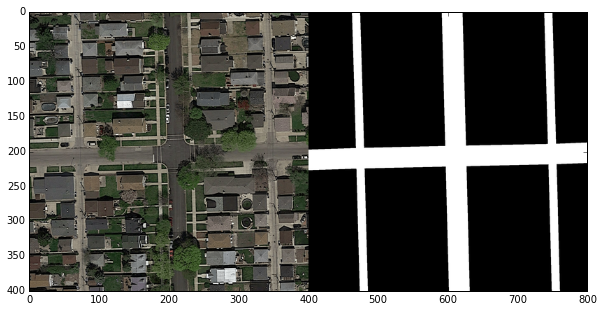

In [57]:
print('Image size = ' + str(org_imgs[0].shape[0]) + ',' + str(org_imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(org_imgs[0], gt_imgs[0])
print('image is of type '+ str(type(org_imgs[0])))
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

image is of type <type 'numpy.ndarray'>
image dimensiotns are (412, 412, 3)


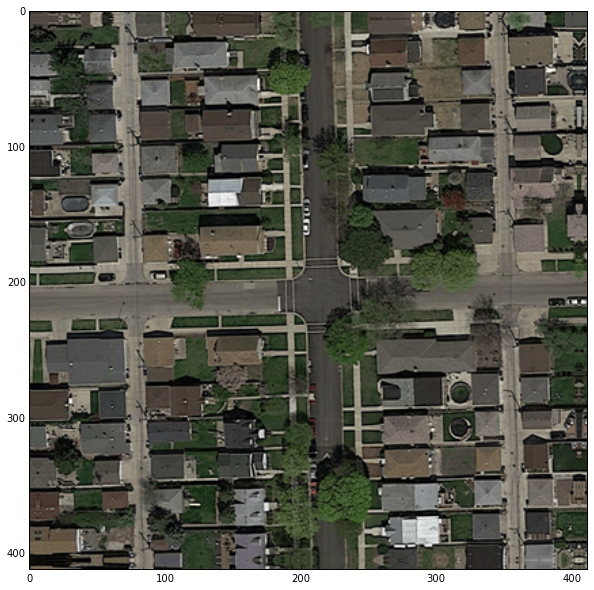

In [10]:
# create padded images, then extract patches

patch_size = 13 # patches are patch_size^2
pad_size = (patch_size -1) / 2
if (patch_size % 2 != 1):
    raise Warning("patch_size should be odd number")

# NOTE this creates files in root_dir/training_pad
save_to_file = False
pad_imgs = [0] * n
for i in range (n):
    save_path = root_dir + 'padded/padded_satImage_' + str(i+1).zfill(3) + '.png'
    pad_imgs[i] = make_pad_img(org_imgs[i], pad_size = pad_size, input_method = 'image')
    if save_to_file:
        pad_imgs[i].save(save_path, 'PNG')
    pad_imgs[i] = np.asarray(pad_imgs[i])

# dimensions of each padded image
temp = pad_imgs[0]
print('image is of type '+ str(type(temp)))
print('image dimensiotns are ' + str(np.shape(temp)))
fig2 = plt.figure(figsize=(10, 10))
plt.imshow(temp)


In [36]:
# Extract patches from input images

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [37]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

In [38]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [39]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 11560 features
Feature dimension = 2
Number of classes = 1
Class 0: 8437 samples
Class 1: 3123 samples


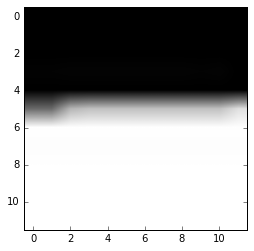

In [40]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

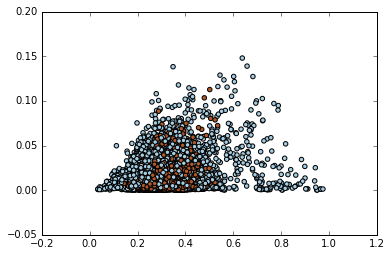

In [41]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [42]:
# import pip
# def install(package):
#     pip.main(['install', package])
# if __name__ == '__main__':
#     install('scikit-learn')

In [43]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [44]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

True positive rate = 0.17223183391


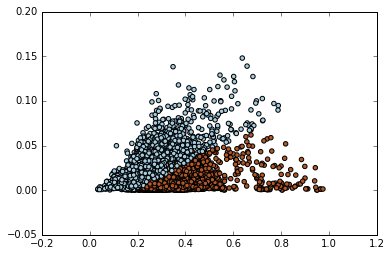

In [45]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [46]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

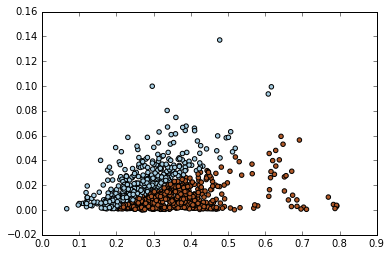

In [47]:
# Run prediction on the img_idx-th image
img_idx = 14

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

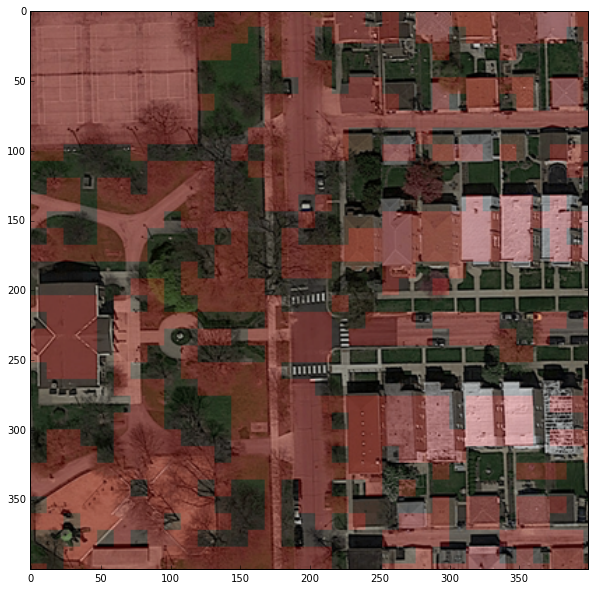

In [48]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)
